# LEV / GSW overlay

Various methods for overlaying emergent lake vegetation rasters over Pekel/GSW inundation rasters. Occurrence seems to perform better than Seasonality.

In [74]:
## Imports
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
from scipy.stats import binned_statistic
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd

In [53]:
## Env vars
reclass_vals_detailed = {
    1:	'dry land',
    2:	'water',
    3:	'wet graminoid',
    4:	'wet shrubs',
    5:	'wet forest',
    25: 'river or bridge',
    30: 'urban',
    35: 'non-roi',
    42:	'water no lake',
    43:	'wet graminoid no lake',
    44: 'wet shrubs no lake',
    45: 'wet forest no lake',
    52: 'water not valid'}

reclass_vals_simple = {
    1:	'dry land',
    2:	'water',
    3:	'LEV',
    4:	'LEV',
    5:	'LEV',
    25: 'invalid', 
    30: 'invalid', 
    35: 'invalid', 
    42:	'invalid', 
    43:	'invalid', 
    44: 'invalid', 
    45: 'invalid', 
    52: 'invalid'}

## Method A: Load from GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Zonal histogram based on DN field

In Python:
1. Aggregate by class
2. Compute confusion matrix and plot histograms

In [45]:
df = gpd.read_file('/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/YFLATS_190914_mosaic_rcls_brn_zHist.shp') # this is zonal histogram of YF UAVSAR against GSW Occurrence
df.head()

,DN,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,...,HISTO_92,HISTO_93,HISTO_94,HISTO_95,HISTO_96,HISTO_97,HISTO_98,HISTO_99,HISTO_100,geometry
0,35,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1975508.149 3758374.790, -1975479.9..."
1,35,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1976801.208 3757285.006, -1976772.9..."
2,35,402.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1976355.131 3757951.299, -1976332.5..."
3,35,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1977840.173 3754744.059, -1977817.5..."
4,35,1336.0,2.0,1.0,2.0,1.0,0.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-1976117.976 3755935.481, -1976089.7..."


In [55]:
## Add actual class name
df['Class'] = df['DN'].apply(lambda x: reclass_vals_detailed[x])
df['Broad_class'] = df['DN'].apply(lambda x: reclass_vals_simple[x])



In [160]:
# Aggregate by class (detailed)
dfg = df.groupby('Class')
df_sums = dfg.sum(numeric_only=True)
df_sums.drop(columns='DN', inplace=True) # drop meaningless columns

# Aggregate by class (simple)
dfgs = df.groupby('Broad_class')
df_sums_s = dfgs.sum(numeric_only=True)
df_sums_s.drop(columns='DN', inplace=True)

df_sums_s

,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,HISTO_9,...,HISTO_91,HISTO_92,HISTO_93,HISTO_94,HISTO_95,HISTO_96,HISTO_97,HISTO_98,HISTO_99,HISTO_100
Broad_class,,,,,,,,,,,,,,,,,,,,,
LEV,162624.0,1219.0,2347.0,2643.0,2275.0,1920.0,1895.0,1635.0,1516.0,1462.0,...,298.0,251.0,167.0,84.0,48.0,45.0,57.0,68.0,5.0,0.0
dry land,4913459.0,4638.0,7189.0,6844.0,5055.0,3701.0,3086.0,2741.0,2484.0,2421.0,...,491.0,493.0,513.0,471.0,690.0,1015.0,2076.0,2538.0,460.0,4.0
invalid,7345087.0,8981.0,11176.0,9480.0,7610.0,6588.0,5518.0,5123.0,4722.0,4725.0,...,20750.0,22308.0,24547.0,28814.0,32892.0,38606.0,62286.0,84484.0,19959.0,126.0
water,128087.0,1186.0,2547.0,2467.0,1882.0,1685.0,1524.0,1391.0,1466.0,1379.0,...,15429.0,16441.0,15927.0,10996.0,4679.0,1954.0,5095.0,7415.0,1227.0,12.0


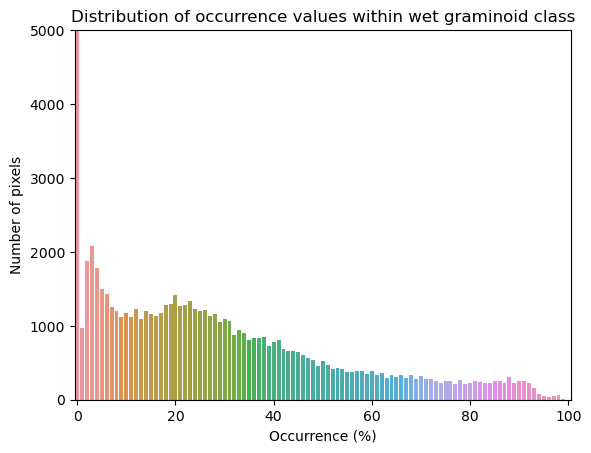

In [61]:
## Plot hist to show: "Within all wet graminoid pixels, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums.loc['wet graminoid', 'HISTO_0':'HISTO_100']
sns.barplot(x=np.arange(0, 101), y=hist_wg)
plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title('Distribution of occurrence values within wet graminoid class')
plt.show()

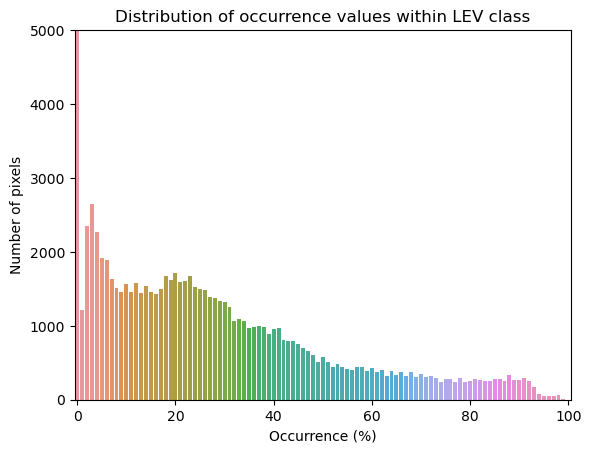

In [64]:
## Plot hist to show: "Within all LEV, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums_s.loc['LEV', 'HISTO_0':'HISTO_100']
sns.barplot(x=np.arange(0, 101), y=hist_wg)
plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title('Distribution of occurrence values within LEV class')
plt.show()

### Now, group occurrence and calculate confusion matrix

In [168]:
## Compute binned statistic
stats_classes = ['LEV', 'SUM'] # 'water'
df_sums_s.loc['SUM', :]=df_sums_s.sum() # occurence bin
bStat = binned_statistic(np.arange(101), values=df_sums_s.loc[stats_classes, :], statistic='sum', bins=[0, 5, 50, 95, 100]) # 
df_sums_s.loc['oc_bin', :]=np.nan # occurence bin
df_sums_s
bStat


BinnedStatisticResult(statistic=array([[1.7110800e+05, 5.7047000e+04, 1.4811000e+04, 2.2300000e+02],
       [1.2626796e+07, 4.1428800e+05, 5.5681600e+05, 2.6574100e+05]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]))

In [169]:
## Construct Confusion Matrix

cm = pd.DataFrame(bStat.statistic[:2], columns = bStat.bin_edges[1:], index = stats_classes[:2])
cm.loc['Other', :] = cm.loc['SUM',:] - cm.loc['LEV', :]
cm.reindex(cm.index[[0,2,1]])

## Construct Confusion Matrix with water
# cm_full = pd.DataFrame(bStat.statistic, columns = bStat.bin_edges[1:], index = stats_classes)
# cm_full.loc['Other', :] = cm_full.loc['SUM',:] - cm_full.loc['LEV', :]
# cm_full.reindex(cm_full.index[[0,2,1]])

,5.0,50.0,95.0,100.0
LEV,171108.0,57047.0,14811.0,223.0
Other,12455688.0,357241.0,542005.0,265518.0
SUM,12626796.0,414288.0,556816.0,265741.0


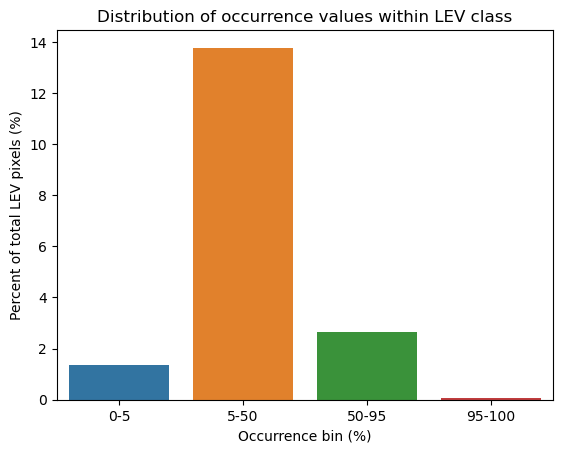

In [170]:
## Plot binned stat
## Plot hist to show: "Within all LEV, what was the binned distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
bin_labels = ['0-5', '5-50', '50-95', '95-100']
sns.barplot(x=cm.columns, y=cm.loc['LEV', :] / cm.loc['SUM', :] * 100)
# plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence bin (%)')
plt.xticks(ticks=np.arange(4), labels = bin_labels)
plt.ylabel('Percent of total LEV pixels (%)')
plt.title('Distribution of occurrence values within LEV class')
plt.show()



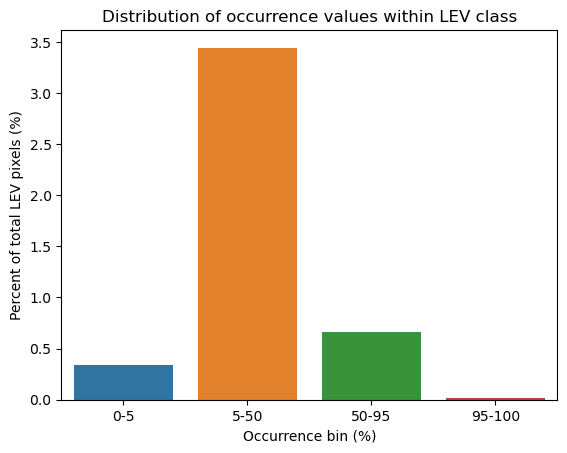

In [ ]:
## Plot binned stat in other dimension
## Plot hist to show: "Within all of one occurrence bin, what was the contribution of LEV values"
'''Almost all WG pixels have 0 occurrence...'''
bin_labels = ['0-5', '5-50', '50-95', '95-100']
sns.barplot(x=cm.columns, y=cm.loc['LEV', :] / cm.loc['SUM', :] * 100)
# plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence bin (%)')
plt.xticks(ticks=np.arange(4), labels = bin_labels)
plt.ylabel('Percent of total LEV pixels (%)')
plt.title('Distribution of occurrence values within LEV class')
plt.show()



### Try to visualize confusion matrix

In [146]:
cm.iloc[:2, :-1].

,0-5,5-50,50-95,95-100
LEV,171108.0,57047.0,14811.0,223.0
SUM,50507184.0,1657152.0,2227264.0,1062964.0


KeyError: (0, 0)

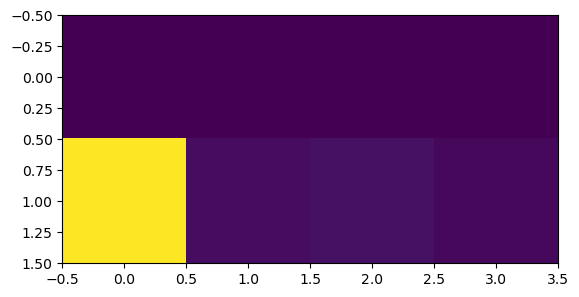

In [130]:
## Visualize CM
from sklearn.metrics import ConfusionMatrixDisplay
cmD = ConfusionMatrixDisplay(cm.iloc[:2, :])
# cmD.
cmD.plot()

### CM viz V2

In [152]:
## Add row sum
# cm.columns = ['0-5', '5-50', '50-95', '95-100'] # comment out if already run
# cm['SUM'] = cm.sum(axis=1)
cm.astype('int')

,0-5,5-50,50-95,95-100,SUM
LEV,171108,57047,14811,223,243189
SUM,50507184,1657152,2227264,1062964,55454564
Other,50336076,1600105,2212453,1062741,55211375


KeyError: (0, 0)

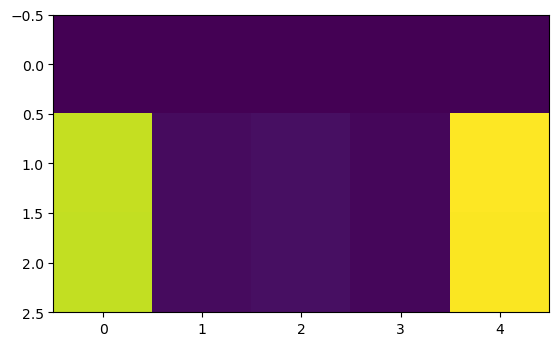

In [148]:
cmD = ConfusionMatrixDisplay(cm)
# cmD = ConfusionMatrixDisplay(cm.iloc[:2, :4])
# cmD.
cmD.plot()

## Method B: Load from lengthy GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Dissolve based on DN field to get only n entries corresponding to n classes
2. Zonal histogram based on DN field

In [30]:
## Load file that has already been aggregated through verrry slow QGIS dissolve by DN
df = gpd.read_file('/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/dissolved/zonal_hist/YFLATS_190914_mosaic_rcls_brn_ds_Occurrence.shp')
df.head()

,DN,geometry
0,35,"MULTIPOLYGON (((-2017546.705 3712282.011, -201..."
1,5,"MULTIPOLYGON (((-2034859.024 3717013.819, -203..."
2,4,"MULTIPOLYGON (((-2057236.298 3723637.221, -205..."
3,3,"MULTIPOLYGON (((-2058766.512 3723947.781, -205..."
4,2,"MULTIPOLYGON (((-2059381.986 3723834.850, -205..."
